In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = "cpu"
num_epochs = 10
learning_rate = 0.001
criterion = loss_fn_v01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    #if (epoch+1) % 20 == 0:
    #    curr_lr /= 3
    #    update_lr(optimizer, curr_lr)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))


In [ ]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


def load_data():
    transform = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        transforms.ToTensor()])

    train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                 train=True, 
                                                 transform=transform,
                                                 download=True)

    test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                train=False, 
                                                transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=100, 
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=100, 
                                              shuffle=False)
    return train_loader, test_loader
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def train_epoch(self, train_loader, optimizer, criterion, device):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = self(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def test(self, data_loader, device):
        self.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return (correct / total)

#model18 = ResNet(ResidualBlock, [2, 2, 2]).to(device)
#model34 = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
#model = model34

#criterion = nn.CrossEntropyLoss()

def loss_fn_v01(pred, y):
    pred = torch.softmax(pred,dim=1)
    pred = pred + 0.001
    logs = torch.log(pred)
    logsum = logs.sum(dim=1)
    sec = 1/pred
    res = logsum
    res = res + sec.gather(1,y.view(-1,1))
    return res.mean()

def loss_fn_v02(pred, y, epsilon=1e-4):
    pred = torch.softmax(pred,dim=1)

    # avoid nan
    pred = pred + epsilon
    pred = pred - (pred/pred.sum()) * (len(pred) * epsilon) #restores probability vector characteristic #TODO is this reaaally necessary?

    logs = torch.log(pred)
    logsum = logs.sum(dim=1)
    sec = 1/pred
    res = logsum
    res = res + sec.gather(1,y.view(-1,1))
    return res.mean()


def loss_fn_v03(pred, y):
    n_classes = pred.shape[1]
    logsumexp = torch.logsumexp(pred, dim=1)
    ys = pred.gather(1,y.view(-1,1))
    expys = torch.exp(ys).flatten()
    res = logsumexp / expys - n_classes * logsumexp + pred.sum(dim=1)
    return res.mean()



In [ ]:
# Import the tuning library from ray
from ray import tune
import matplotlib
import random
random.seed(123)
#inline matplotlib
%inline matplotlib
import os
from datetime import datetime
# Import ASHA Hyperparameter Optimization
from ray.tune.schedulers import ASHAScheduler

In [ ]:
device = "cpu"
patience = 8
def objective(config):
    #train_loader, test_loader
    train_loader, test_loader = load_data()
    model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    # Use function arguments for the optimizer to tune it
    #optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    criterion = config["criterion"]
    # start training loop
    acc_best = 0
    patience_acc = 0
    epoch = 0
    while True:
        epoch += 1
        model.train_epoch(train_loader, optimizer, criterion, device)
        acc = model.test(test_loader, device)
        with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
            path = os.path.join(checkpoint_dir, "checkpoint")
            save_obj = (model.state_dict(), optimizer.state_dict())
            torch.save(save_obj, path)
        if acc_best > acc:
            patience_acc += 1
        else:
            patience_acc = 0
            acc_best = acc

        if patience_acc >= patience:
            tune.report(accuracy=acc, done=True)
        else:
            tune.report(accuracy=acc, done=False)


search_space = {
    "lr": tune.grid_search([0.0001, 0.0005, 0.001, 0.005, 0.01]),
    "criterion": tune.grid_search([loss_fn_v01, loss_fn_v02, nn.CrossEntropyLoss()]),
  }

resources_per_trial = {"cpu": 1, "gpu": 0}
analysis = tune.run(
    objective,
    config=search_space,
    resources_per_trial=resources_per_trial,
    # a single sample is the default and useful for grid_search
    # but if we have an infinite space, we will need more
    num_samples=1,
)

In [ ]:
# Import the tuning library from ray
from ray import tune
import os
from datetime import datetime
from ray.tune.schedulers import ASHAScheduler

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


def load_data():
    transform = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        transforms.ToTensor()])

    train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                 train=True, 
                                                 transform=transform,
                                                 download=True)

    test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                train=False, 
                                                transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=100, 
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=100, 
                                              shuffle=False)
    return train_loader, test_loader
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def train_epoch(self, train_loader, optimizer, criterion, device):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = self(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def test(self, data_loader, device):
        self.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return (correct / total)

#model18 = ResNet(ResidualBlock, [2, 2, 2]).to(device)
#model34 = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
#model = model34

#criterion = nn.CrossEntropyLoss()

def loss_fn_v01(pred, y):
    pred = torch.softmax(pred,dim=1)
    pred = pred + 0.001
    logs = torch.log(pred)
    logsum = logs.sum(dim=1)
    sec = 1/pred
    res = logsum
    res = res + sec.gather(1,y.view(-1,1))
    return res.mean()

def loss_fn_v02(pred, y, epsilon=1e-4):
    pred = torch.softmax(pred,dim=1)

    # avoid nan
    pred = pred + epsilon
    pred = pred - (pred/pred.sum()) * (len(pred) * epsilon) #restores probability vector characteristic #TODO is this reaaally necessary?

    logs = torch.log(pred)
    logsum = logs.sum(dim=1)
    sec = 1/pred
    res = logsum
    res = res + sec.gather(1,y.view(-1,1))
    return res.mean()


def loss_fn_v03(pred, y):
    n_classes = pred.shape[1]
    logsumexp = torch.logsumexp(pred, dim=1)
    ys = pred.gather(1,y.view(-1,1))
    expys = torch.exp(ys).flatten()
    res = logsumexp / expys - n_classes * logsumexp + pred.sum(dim=1)
    return res.mean()


device = "cpu"
patience = 8
def objective(config):
    #train_loader, test_loader
    train_loader, test_loader = load_data()
    model = ResNet(ResidualBlock, [2, 2, 2]).to(device)
    # Use function arguments for the optimizer to tune it
    #optimizer = torch.optim.SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    optimizer = torch.optim.Adam(model.parameters(), lr=config["lr"])
    criterion = config["criterion"]
    # start training loop
    acc_best = 0
    patience_acc = 0
    epoch = 0
    while True:
        epoch += 1
        model.train_epoch(train_loader, optimizer, criterion, device)
        acc = model.test(test_loader, device)
        #with tune.checkpoint_dir(step=epoch) as checkpoint_dir:
        #    path = os.path.join(checkpoint_dir, "checkpoint")
        #    save_obj = (model.state_dict(), optimizer.state_dict())
        #    torch.save(save_obj, path)
        if acc_best > acc:
            patience_acc += 1
        else:
            patience_acc = 0
            acc_best = acc

        if patience_acc >= patience:
            tune.report(accuracy=acc, done=True)
        else:
            tune.report(accuracy=acc, done=False)


search_space = {
    "lr": tune.grid_search([0.0001, 0.0005, 0.001, 0.005, 0.01]),
    "criterion": tune.grid_search([loss_fn_v01, loss_fn_v02, nn.CrossEntropyLoss()]),
  }

resources_per_trial = {"cpu": 1, "gpu": 0}
analysis = tune.run(
    objective,
    config=search_space,
    resources_per_trial=resources_per_trial,
    # a single sample is the default and useful for grid_search
    # but if we have an infinite space, we will need more
    num_samples=1,
    #local_dir="./results", 
    #name="main_experiment",
    log_to_file=True,
)

In [ ]:
#analysis.get_best_config(metric='accuracy', mode='max')
#analysis.dataframe()

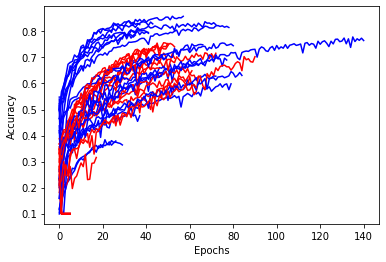

In [31]:
from turtle import color
from ray.tune import ExperimentAnalysis
analysis = ExperimentAnalysis("./results/main_experiment_v02")
def plot(analysis):
    ax = None
    dfs = analysis.trial_dataframes
    for k, d in dfs.items():
        if "v01" in k:
            ax = d.accuracy.plot(ax=ax, legend=False, color="red")
        else:
            ax = d.accuracy.plot(ax=ax, legend=False, color="blue")
    ax.set_xlabel("Epochs")
    ax.set_ylabel("Accuracy");
plot(analysis)


In [26]:
from ray.tune import ExperimentAnalysis
analysis = ExperimentAnalysis("./results/main_experiment_v02")
res = analysis.dataframe()
res.drop(columns=["experiment_id","iterations_since_restore", "timestamp", "node_ip", "timesteps_total", "time_this_iter_s", "done", "trial_id", "date", "time_since_restore", "timesteps_since_restore", "episodes_total", "hostname", "pid", "time_total_s"], inplace=True)
res.sort_values(by=["accuracy"], ascending=False, inplace=True)
res[res["config/criterion"].str.contains("v01")]

,accuracy,training_iteration,warmup_time,config/architecture,config/criterion,config/lr,config/optimizer,logdir
31,0.7535,51,0.007046,"[3, 3, 3]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0005,<class 'torch.optim.adam.Adam'>,/home/preich/itakura-saito-loss/results/main_e...
44,0.7461,51,0.013967,"[3, 3, 3]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0010,<class 'torch.optim.adam.Adam'>,/home/preich/itakura-saito-loss/results/main_e...
38,0.7410,54,0.017088,"[2, 2, 2]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0010,<class 'torch.optim.adam.Adam'>,/home/preich/itakura-saito-loss/results/main_e...
12,0.7160,73,0.008048,"[0, 0, 0]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0005,<class 'torch.optim.adam.Adam'>,/home/preich/itakura-saito-loss/results/main_e...
26,0.7154,45,0.010131,"[2, 2, 2]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0005,<class 'torch.optim.adam.Adam'>,/home/preich/itakura-saito-loss/results/main_e...
41,0.7029,91,0.006557,"[2, 2, 2]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0001,<class 'torch.optim.sgd.SGD'>,/home/preich/itakura-saito-loss/results/main_e...
23,0.6969,54,0.022778,"[0, 0, 0]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0010,<class 'torch.optim.adam.Adam'>,/home/preich/itakura-saito-loss/results/main_e...
20,0.6772,44,0.014995,"[1, 1, 1]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0005,<class 'torch.optim.adam.Adam'>,/home/preich/itakura-saito-loss/results/main_e...
21,0.6577,47,0.010576,"[3, 3, 3]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0001,<class 'torch.optim.adam.Adam'>,/home/preich/itakura-saito-loss/results/main_e...
15,0.6486,62,0.007104,"[2, 2, 2]",<function loss_fn_v01 at 0x7f63da85bee0>,0.0001,<class 'torch.optim.adam.Adam'>,/home/preich/itakura-saito-loss/results/main_e...


In [ ]:
from ray import tune
import os
from datetime import datetime
from ray.tune.schedulers import ASHAScheduler

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms


def load_data():
    transform = transforms.Compose([
        transforms.Pad(4),
        transforms.RandomHorizontalFlip(),
        transforms.RandomCrop(32),
        transforms.ToTensor()])

    train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                 train=True, 
                                                 transform=transform,
                                                 download=True)

    test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                                train=False, 
                                                transform=transforms.ToTensor())

    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                               batch_size=100, 
                                               shuffle=True)
    test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                              batch_size=100, 
                                              shuffle=False)
    return train_loader, test_loader
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

    def train_epoch(self, train_loader, optimizer, criterion, device):
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = self(images)
            loss = criterion(outputs, labels)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    def test(self, data_loader, device):
        self.eval()
        with torch.no_grad():
            correct = 0
            total = 0
            for images, labels in data_loader:
                images = images.to(device)
                labels = labels.to(device)
                outputs = self(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        
        return (correct / total)

#model18 = ResNet(ResidualBlock, [2, 2, 2]).to(device)
#model34 = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device)
#model = model34

#criterion = nn.CrossEntropyLoss()

def loss_fn_v01(pred, y):
    pred = torch.softmax(pred,dim=1)
    pred = pred + 0.001
    logs = torch.log(pred)
    logsum = logs.sum(dim=1)
    sec = 1/pred
    res = logsum
    res = res + sec.gather(1,y.view(-1,1))
    return res.mean()

def loss_fn_v02(pred, y, epsilon=1e-4):
    pred = torch.softmax(pred,dim=1)

    # avoid nan
    pred = pred + epsilon
    pred = pred - (pred/pred.sum()) * (len(pred) * epsilon) #restores probability vector characteristic #TODO is this reaaally necessary?

    logs = torch.log(pred)
    logsum = logs.sum(dim=1)
    sec = 1/pred
    res = logsum
    res = res + sec.gather(1,y.view(-1,1))
    return res.mean()


def loss_fn_v03(pred, y):
    n_classes = pred.shape[1]
    logsumexp = torch.logsumexp(pred, dim=1)
    ys = pred.gather(1,y.view(-1,1))
    expys = torch.exp(ys).flatten()
    res = logsumexp / expys - n_classes * logsumexp + pred.sum(dim=1)
    return res.mean()

device = "cuda"
train_loader, test_loader = load_data()
model = ResNet(ResidualBlock, [1, 0, 0]).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = loss_fn_v01
for i in range(10):
    model.train_epoch(train_loader, optimizer, criterion, device)
    acc = model.test(test_loader, device)
    print(acc)

In [3]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_epochs = 10
learning_rate = 0.001
transform = transforms.Compose([
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32),
    transforms.ToTensor()])

train_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                             train=True, 
                                             transform=transform,
                                             download=True)

test_dataset = torchvision.datasets.CIFAR10(root='./data/',
                                            train=False, 
                                            transform=transforms.ToTensor())

train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=100, 
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                          batch_size=100, 
                                          shuffle=False)
# 3x3 convolution
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                     stride=stride, padding=1, bias=False)
# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out
# ResNet
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_channels = 16
        self.conv = conv3x3(3, 16)
        self.bn = nn.BatchNorm2d(16)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 16, layers[0])
        self.layer2 = self.make_layer(block, 32, layers[1], 2)
        self.layer3 = self.make_layer(block, 64, layers[2], 2)
        self.avg_pool = nn.AvgPool2d(8)
        self.fc = nn.Linear(64, num_classes)

    def make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels))
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, blocks):
            layers.append(block(out_channels, out_channels))
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.avg_pool(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out

model = ResNet(ResidualBlock, [0, 0, 0]).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()

def loss_fn_v01(pred, y):
    pred = torch.softmax(pred,dim=1)
    pred = pred + 0.001
    logs = torch.log(pred)
    logsum = logs.sum(dim=1)
    sec = 1/pred
    res = logsum
    res = res + sec.gather(1,y.view(-1,1))
    return res.mean()

def loss_fn_v02(pred, y):
    n_classes = pred.shape[1]
    logsumexp = torch.logsumexp(pred, dim=1)
    ys = pred.gather(1,y.view(-1,1))
    expys = torch.exp(ys).flatten()
    res = logsumexp / expys - n_classes * logsumexp + pred.sum(dim=1)
    return res.mean()

criterion = loss_fn_v01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# For updating learning rate
def update_lr(optimizer, lr):    
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
# Train the model
total_step = len(train_loader)
curr_lr = learning_rate
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (i+1) % 100 == 0:
            print ("Epoch [{}/{}], Step [{}/{}] Loss: {:.4f}"
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Decay learning rate
    #if (epoch+1) % 20 == 0:
    #    curr_lr /= 3
    #    update_lr(optimizer, curr_lr)

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print('Accuracy of the model on the test images: {} %'.format(100 * correct / total))

Files already downloaded and verified
Epoch [1/10], Step [100/500] Loss: -18.0501
Epoch [1/10], Step [200/500] Loss: -24.7236
Epoch [1/10], Step [300/500] Loss: -22.3276
Epoch [1/10], Step [400/500] Loss: -26.0780
Epoch [1/10], Step [500/500] Loss: -22.1993
Epoch [2/10], Step [100/500] Loss: -14.6081
Epoch [2/10], Step [200/500] Loss: -28.4595
Epoch [2/10], Step [300/500] Loss: -25.4283
Epoch [2/10], Step [400/500] Loss: -29.2995
Epoch [2/10], Step [500/500] Loss: -28.4675
Epoch [3/10], Step [100/500] Loss: -19.7596
Epoch [3/10], Step [200/500] Loss: -27.1998
Epoch [3/10], Step [300/500] Loss: -31.6921
Epoch [3/10], Step [400/500] Loss: -23.0067
